In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
import math

import pandas as pd
import xarray as xr

import os
import qcodes as qc
from qcodes.dataset.data_set import DataSet, new_data_set
from qcodes.dataset.experiment_container import load_experiment_by_name, new_experiment
from qcodes.dataset.measurements import ParamSpec
from qcodes.dataset.sqlite_base import (connect, get_dependencies,
                                        get_dependents, get_layout, get_runs)

In [182]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from plottr.data.datadict import DataDict
from plottr.data.qcodes import DataSetDict

In [3]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [4]:
def centers2edges(arr):
    e = (arr[1:] + arr[:-1]) / 2.
    e = np.concatenate(([arr[0] - (e[0] - arr[0])], e))
    e = np.concatenate((e, [arr[-1] + (arr[-1] - e[-1])]))
    return e

def pcolorgrid(xaxis, yaxis):
    xedges = centers2edges(xaxis)
    yedges = centers2edges(yaxis)
    xx, yy = np.meshgrid(xedges, yedges)
    return xx, yy

def pcolormesh(ax, x, y, z, **kw):
    xx, yy = pcolorgrid(x, y)
    im = ax.pcolormesh(xx, yy, z, **kw)
    return im

## Frequency sweeps

In [192]:
def res_fit(f, f0, q, smin, a):
    df = (f-f0)/f0
    s = a*((smin/a)+2j*q*df)/(1+2j*q*df)
    return abs(s)

### Frequency versus magnetic field

<IPython.core.display.Javascript object>


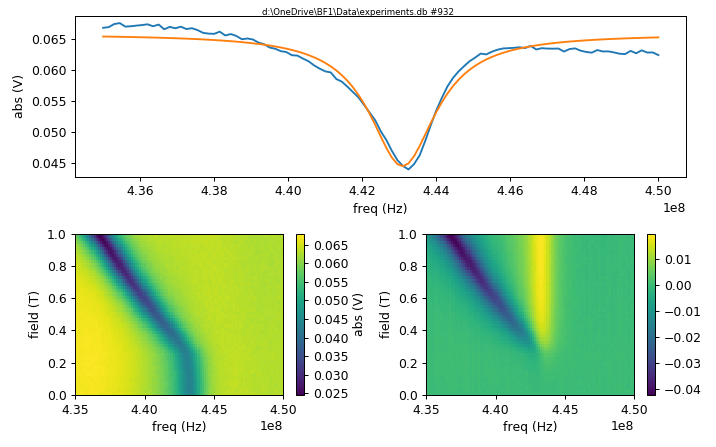

In [345]:
run_id = 932
data = DataSetDict(run_id=run_id)
q = data.get_snapshot()

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

freq = ret['het_src_frequency']
B = ret['AMI430_field']

popt, pcov = curve_fit(res_fit, freq, mag[:,0], p0 = [4.44e8, 200, 0.045, 0.065])
# popt, pcov = curve_fit(res_fit, freq, mag[:,15], p0 = [4.43e8, 200, 0.045, 0.065])

fig = plt.figure(figsize=(8,5))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)


im1 = ax1.plot(freq, mag[:,0])
ax1.plot(freq, res_fit(freq, *popt))
ax1.set_xlabel('freq (Hz)')
ax1.set_ylabel("abs (V)")


im2 = ax2.pcolor(freq, B, mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
ax2.set_xlabel('freq (Hz)')
ax2.set_ylabel('field (T)')
cb2.set_label('abs (V)')

im3 = ax3.pcolor(freq, B, mag.T-mag[:,0])
cb2 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('freq (Hz)')
ax3.set_ylabel('field (T)')
cb3.set_label('abs (V)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

<IPython.core.display.Javascript object>


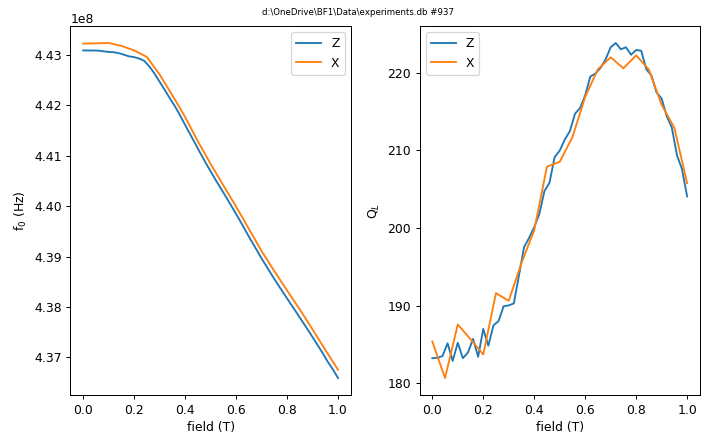

443223813.84306061

In [343]:
run_id = 932
data = DataSetDict(run_id=run_id)
q = data.get_snapshot()

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

freq = ret['het_src_frequency']
B = ret['AMI430_field']

res = []
freq0 = []
Qres0 = []
fguess= 4.43e8
for i in range(B.size):
    popt, pcov = curve_fit(res_fit, freq, mag[:,i], p0 = [fguess, 200, 0.045, 0.065])
    fguess = popt[0]
    res.append([*popt])
    freq0.append(popt[0])
    Qres0.append(popt[1])


freq0 = np.array(freq0)
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
ax1.plot(B, freq0, label = 'Z')
ax1.set_xlabel('field (T)')
ax1.set_ylabel(r'f$_0$ (Hz)')

ax2.plot(B, Qres0, label = 'Z')
# print(freq0[-1])
ax2.set_xlabel('field (T)')
ax2.set_ylabel(r'Q$_L$')


run_id = 937
data = DataSetDict(run_id=run_id)
q = data.get_snapshot()

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

freq = ret['het_src_frequency']
B = ret['AMI430_field']

res = []
freq1 = []
Qres1 = []
fguess= 4.43e8
for i in range(B.size):
    popt, pcov = curve_fit(res_fit, freq, mag[:,i], p0 = [fguess, 200, 0.045, 0.065])
    fguess = popt[0]
    res.append([*popt])
    freq1.append(popt[0])
    Qres1.append(popt[1])


freq0 = np.array(freq0)
    
# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
ax1.plot(B, freq1, label = 'X')
ax1.set_xlabel('field (T)')
ax1.set_ylabel(r'f$_0$ (Hz)')

ax2.plot(B, Qres1, label = 'X')
# print(freq0[-1])
ax2.set_xlabel('field (T)')
ax2.set_ylabel(r'Q$_L$')

ax1.legend()
ax2.legend()

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

freq1[0]


## Hard sweeps

### Diamond scan

<IPython.core.display.Javascript object>


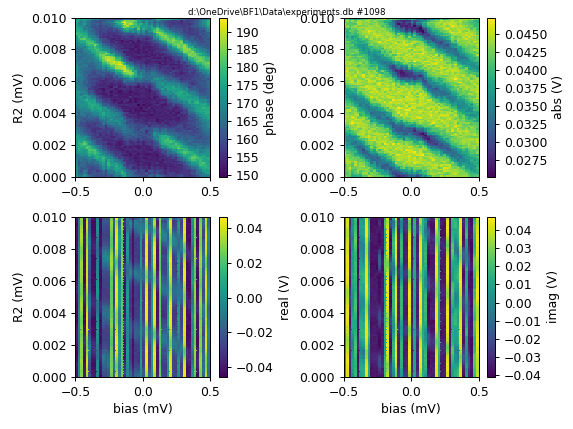

In [653]:
run_id = 1098

data = DataSetDict(run_id=run_id)

data.structure()

# q = data.get_snapshot()
# print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
# dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
# dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
# dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
# print('T2 ' + str(dac10) + ' mV')
# print('T3 ' + str(dac8) + ' mV')
# print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,1]
real = ret_r['avgiq_detector_signal_real'][:,:,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,1]

mag_ref  = ret['avgiq_detector_signal_abs'][:,:,0]
real_ref = ret_r['avgiq_detector_signal_real'][:,:,0]
imag_ref = ret_i['avgiq_detector_signal_imag'][:,:,0]

z = real+1j*imag
phi = np.angle(z, deg=1)

z_ref = real_ref+1j*imag_ref
phi_ref = np.angle(z_ref, deg=1)

r2 = np.flip(ret['awg_ramp_voltage_vals'],0)
bias = ret['ivvi_setup_dac4']*1e3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im1 = ax1.pcolor(bias, r2, ((phi-phi_ref)%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(bias, r2, mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(bias, r2, real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('bias (mV)')
ax3.set_ylabel("R2 (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(bias, r2, imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('bias (mV)')
cb4.set_label('imag (V)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

### Charge stability diagram

<IPython.core.display.Javascript object>


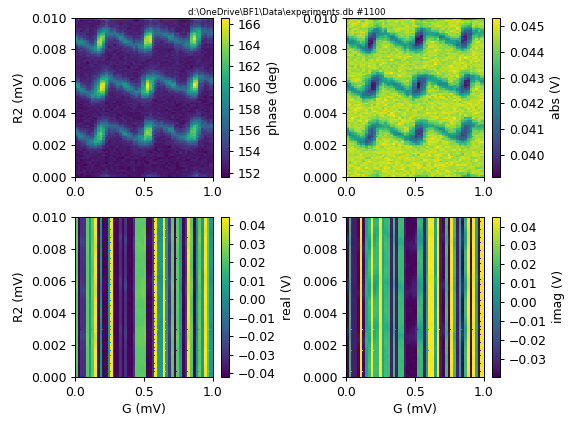

In [675]:
run_id = 1100

data = DataSetDict(run_id=run_id)

data.structure()

# q = data.get_snapshot()
# print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
# dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
# dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
# dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
# print('T2 ' + str(dac10) + ' mV')
# print('T3 ' + str(dac8) + ' mV')
# print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,1]
real = ret_r['avgiq_detector_signal_real'][:,:,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,1]

mag_ref  = ret['avgiq_detector_signal_abs'][:,:,0]
real_ref = ret_r['avgiq_detector_signal_real'][:,:,0]
imag_ref = ret_i['avgiq_detector_signal_imag'][:,:,0]

z = real+1j*imag
phi = np.angle(z, deg=1)

z_ref = real_ref+1j*imag_ref
phi_ref = np.angle(z_ref, deg=1)

r2 = np.flip(ret['awg_ramp_voltage_vals'],0)
# r2 = ret['awg_ramp_voltage_vals']
bias = ret['ivvi_setup_dac16']*1e3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im1 = ax1.pcolor(bias, r2, ((phi-phi_ref)%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(bias, r2, mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(bias, r2, real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('G (mV)')
ax3.set_ylabel("R2 (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(bias, r2, imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('G (mV)')
cb4.set_label('imag (V)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## RF diamond scan

field 2.7857315017783033e-05 T
T2 0.0 mV
T3 -460.0 mV
T4 -320.0 mV


<IPython.core.display.Javascript object>


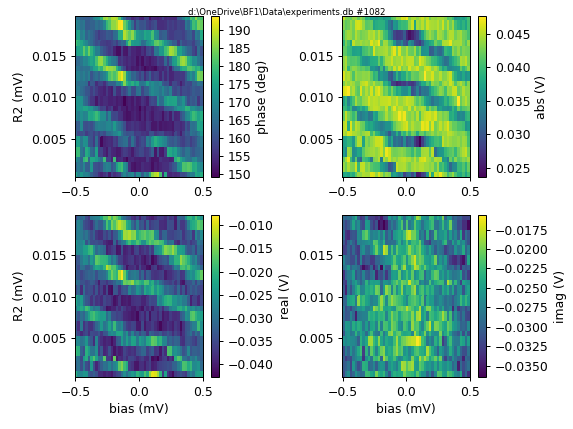

In [636]:
run_id = 1082

data = DataSetDict(run_id=run_id)
q = data.get_snapshot()
print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T2 ' + str(dac10) + ' mV')
print('T3 ' + str(dac8) + ' mV')
print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

mag_ref  = ret['avgiq_detector_signal_abs'][:,:,0,0]
real_ref = ret_r['avgiq_detector_signal_real'][:,:,0,0]
imag_ref = ret_i['avgiq_detector_signal_imag'][:,:,0,0]


z = real+1j*imag
phi = np.angle(z, deg=1)

z_ref = real_ref+1j*imag_ref
phi_ref = np.angle(z_ref, deg=1)

r2 = np.flip(ret['ivvi_setup_dac7'],0)*1e3
bias = ret['ivvi_setup_dac4']*1e3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im1 = ax1.pcolor(bias, r2, ((phi-phi_ref)%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(bias, r2, mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(bias, r2, real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('bias (mV)')
ax3.set_ylabel("R2 (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(bias, r2, imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('bias (mV)')
cb4.set_label('imag (V)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## Gate sweep

field 2.7857315017783033e-05 T
T2 0.0 mV
T3 -460.0 mV
T4 -320.0 mV


<IPython.core.display.Javascript object>


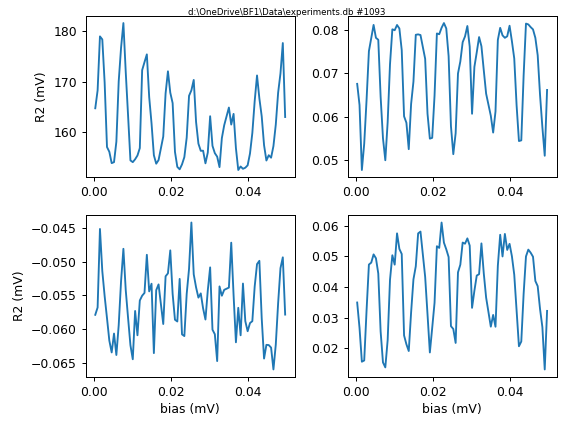

In [645]:
run_id = 1093

data = DataSetDict(run_id=run_id)
q = data.get_snapshot()
print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T2 ' + str(dac10) + ' mV')
print('T3 ' + str(dac8) + ' mV')
print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,0,1]

mag_ref  = ret['avgiq_detector_signal_abs'][:,0,0]
real_ref = ret_r['avgiq_detector_signal_real'][:,0,0]
imag_ref = ret_i['avgiq_detector_signal_imag'][:,0,0]


z = real+1j*imag
phi = np.angle(z, deg=1)

z_ref = real_ref+1j*imag_ref
phi_ref = np.angle(z_ref, deg=1)

r2 = np.flip(ret['ivvi_setup_dac7'],0)*1e3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im1 = ax1.plot(r2, ((phi-phi_ref)%360.0).T)
ax1.set_ylabel("R2 (mV)")

im2 = ax2.plot(r2, mag.T)

im3 = ax3.plot(r2, real.T)
ax3.set_xlabel('bias (mV)')
ax3.set_ylabel("R2 (mV)")


im4 = ax4.plot(r2, imag.T)
ax4.set_xlabel('bias (mV)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## RF Diamonds phase only

T3 -460.0 mV
T4 -410.0 mV


<IPython.core.display.Javascript object>


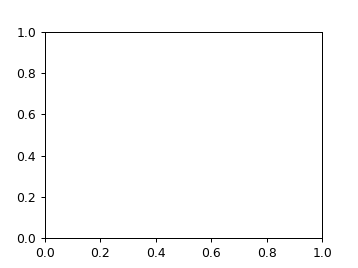

KeyError: 'ivvi_setup_dac4'

In [665]:
run_id = 912
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()

dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T3 ' + str(dac8) + ' mV')
print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

r2 = np.flip(ret['ivvi_setup_dac7'],0)*1e3

fig, ax1 = plt.subplots(1,1, figsize=(4,3))
im1 = ax1.pcolor(ret['ivvi_setup_dac4']*1e3, r2, ((phi+20)%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
ax1.set_xlabel('bias (mV)')
cb1.set_label('phase (deg)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## RF charge stability diagram

In [346]:
run_id = 938
data = DataSetDict(run_id=run_id)
q = data.get_snapshot()
print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T2 ' + str(dac10) + ' mV')
print('T3 ' + str(dac8) + ' mV')
print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

r2 = np.flip(ret['ivvi_setup_dac7'],0)*1e3
G = ret['ivvi_setup_dac16']*1e3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im1 = ax1.pcolor(G, r2, (phi%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(G, r2, mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(G, r2, real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('G (mV)')
ax3.set_ylabel("R2 (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(G, r2, imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('G (mV)')
cb4.set_label('imag (V)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

field 1.0 T
T2 0.0 mV
T3 -350.0 mV
T4 -400.0 mV


KeyError: 'ivvi_setup_dac16'

## RF CSD only phase

T3 -460.0 mV


<IPython.core.display.Javascript object>


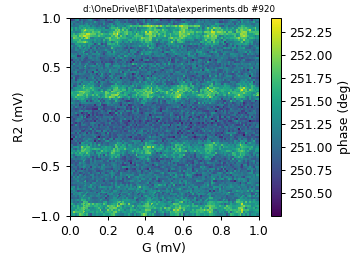

In [673]:
run_id = 920
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()

dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T3 ' + str(dac8) + ' mV')
# print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

r2 = np.flip(ret['ivvi_setup_dac7'],0)*1e3

fig, ax1 = plt.subplots(1,1, figsize=(4,3))
im1 = ax1.pcolor(ret['ivvi_setup_dac16']*1e3, r2, (phi%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
ax1.set_xlabel('G (mV)')
cb1.set_label('phase (deg)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## Field alignment

### gap measurement

-460.0 -750.0


<IPython.core.display.Javascript object>


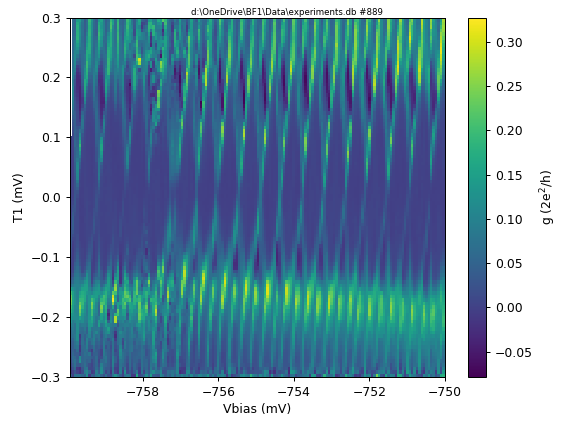

In [50]:
run_id = 889
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac15 = q['station']['instruments']['ivvi']['parameters']['dac15']['value']
print(dac8, dac15)

ret = dict(data.get_grid('ivvi_setup_g_measurement'))
gate = ret['ivvi_setup_dac15']*1e3
bias = ret['ivvi_setup_dac4']*1e3

gate_cut = -755
cut_idx  = np.argmin(abs(gate - gate_cut))

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(gate, bias, ret['ivvi_setup_g_measurement'].T)
cb1 = fig.colorbar(im1, ax=ax1)
# ax1.axhline(y=gate_cut)
ax1.set_ylabel("T1 (mV)")
ax1.set_xlabel('Vbias (mV)')
cb1.set_label(r'g (2e$^2$/h)')

# ax2.plot(bias, ret['ivvi_setup_g_measurement'][cut_idx,:], label='T3 = ' + str(gate_cut) + 'mV')
# ax2.set_ylabel(r'g (2e$^2$/h)')
# ax2.set_xlabel(r"Vbias (mV)")
# ax2.legend()

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

### Theta versus bias

dict_keys(['AMI430_theta', 'ivvi_setup_dac4', 'ivvi_setup_g_measurement'])


<IPython.core.display.Javascript object>


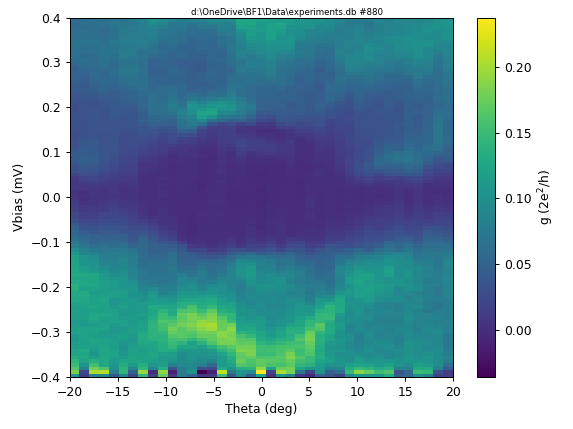

In [36]:
run_id = 880
data = DataSetDict(run_id=run_id)

print(ret.keys())

ret = dict(data.get_grid('ivvi_setup_g_measurement'))
theta = ret['AMI430_theta']
bias = ret['ivvi_setup_dac4']*1e3

# gate_cut = -312
# cut_idx  = np.argmin(abs(gate - gate_cut))

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(theta, bias, ret['ivvi_setup_g_measurement'].T)
cb1 = fig.colorbar(im1, ax=ax1)
# ax1.axhline(y=gate_cut)
ax1.set_ylabel("Vbias (mV)")
ax1.set_xlabel('Theta (deg)')
cb1.set_label(r'g (2e$^2$/h)')

# ax2.plot(bias, ret['ivvi_setup_g_measurement'][cut_idx,:], label='T3 = ' + str(gate_cut) + 'mV')
# ax2.set_ylabel(r'g (2e$^2$/h)')
# ax2.set_xlabel(r"Vbias (mV)")
# ax2.legend()

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

### Field versus bias

dict_keys(['AMI430_field', 'ivvi_setup_dac4', 'ivvi_setup_g_measurement'])


<IPython.core.display.Javascript object>


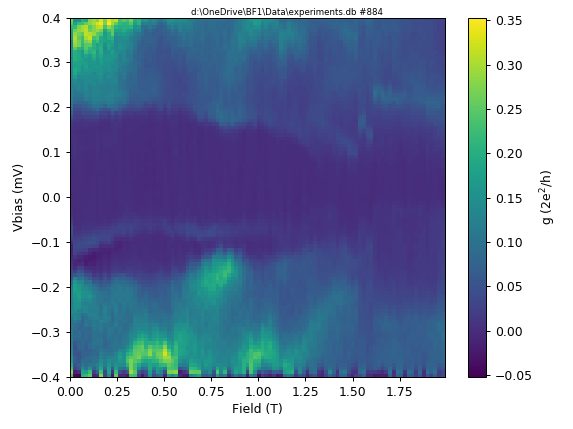

In [41]:
run_id = 884
data = DataSetDict(run_id=run_id)

print(ret.keys())

ret = dict(data.get_grid('ivvi_setup_g_measurement'))
field = ret['AMI430_field']
bias = ret['ivvi_setup_dac4']*1e3

# gate_cut = -312
# cut_idx  = np.argmin(abs(gate - gate_cut))

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(field, bias, ret['ivvi_setup_g_measurement'].T)
cb1 = fig.colorbar(im1, ax=ax1)
# ax1.axhline(y=gate_cut)
ax1.set_ylabel("Vbias (mV)")
ax1.set_xlabel('Field (T)')
cb1.set_label(r'g (2e$^2$/h)')

# ax2.plot(bias, ret['ivvi_setup_g_measurement'][cut_idx,:], label='T3 = ' + str(gate_cut) + 'mV')
# ax2.set_ylabel(r'g (2e$^2$/h)')
# ax2.set_xlabel(r"Vbias (mV)")
# ax2.legend()

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## Gate versus gate

### G vs T

In [445]:
run_id = 946
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac15 = q['station']['instruments']['ivvi']['parameters']['dac15']['value']
print(dac8, dac15)

ret = dict(data.get_grid('ivvi_setup_i_measurement'))
gate = ret['ivvi_setup_dac15']*1e3
T2 = ret['ivvi_setup_dac8']*1e3

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(gate, T2, ret['ivvi_setup_i_measurement'])
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('T3 (mV)')
cb1.set_label(r'g (2e$^2$/h)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

-500.0 0


KeyError: 'ivvi_setup_i_measurement'

### T vs T

0 0.0


<IPython.core.display.Javascript object>


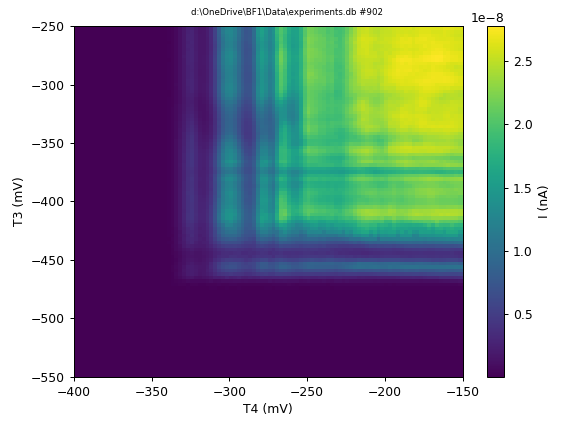

-400.0

In [394]:
run_id = 902
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac15 = q['station']['instruments']['ivvi']['parameters']['dac15']['value']
print(dac8, dac15)

ret = dict(data.get_grid('ivvi_setup_i_measurement'))
T3 = ret['ivvi_setup_dac8']*1e3
T4 = ret['ivvi_setup_dac11']*1e3

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(T3, T4, ret['ivvi_setup_i_measurement'].T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T3 (mV)")
ax1.set_xlabel('T4 (mV)')
cb1.set_label(r'I (nA)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

T3.min()

0 0


<IPython.core.display.Javascript object>


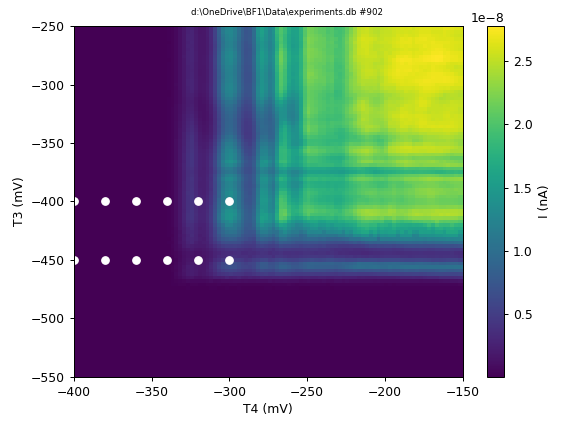

In [533]:
run_id = 902
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print(dac8, dac11)

ret = dict(data.get_grid('ivvi_setup_i_measurement'))
T3 = ret['ivvi_setup_dac8']*1e3
T4 = ret['ivvi_setup_dac11']*1e3

tunnel4 = [-400, -450]
tunnel3 = np.linspace(-400,-300,6)

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(T3, T4, ret['ivvi_setup_i_measurement'].T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T3 (mV)")
ax1.set_xlabel('T4 (mV)')
cb1.set_label(r'I (nA)')

for t3 in tunnel3:
    for t4 in tunnel4:
        ax1.plot(t3, t4, 'wo')
    

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

# Example plot

In [ ]:
data = DataSetDict(run_id=run_id)
ret = dict(data.get_grid('z'))

fig, ax = plt.subplots(1,1)
im = pcolormesh(ax, ret['x'], ret['y'], ret['z'].T)
cb = fig.colorbar(im)
ax.set_xlabel(data.label('x'))
ax.set_ylabel(data.label('y'))
cb.set_label(data.label('z'))